In [87]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import mean_squared_error as mse
from skimage import transform
from skimage.util import invert

# Przygotowanie danych

In [2]:
faces = fetch_olivetti_faces().data

In [3]:
# Helper functions to display a grid of plots
plotGrid_length = 0
plotGrid_height = 0
plotGrid_count = 0
def initPlotGrid(rowLength, totalPlots, showTicks = False):
    global plotGrid_length, plotGrid_count, plotGrid_height
    plotGrid_length = rowLength
    plotGrid_height = (totalPlots // rowLength) + 1 if totalPlots % rowLength > 0 else totalPlots // rowLength
    plotGrid_count = 0
    
    plt.rcParams['figure.figsize'] = [30, 30/plotGrid_length*plotGrid_height*0.8]
    if(not showTicks):
        plt.rcParams['axes.grid'] = False
        plt.rcParams['xtick.labelsize'] = False
        plt.rcParams['ytick.labelsize'] = False
        plt.rcParams['xtick.top'] = False
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['ytick.left'] = False
        plt.rcParams['ytick.right'] = False
    
def addToGrid():
    global plotGrid_length, plotGrid_count
    plt.subplot(plotGrid_height, plotGrid_length, plotGrid_count+1)
    plotGrid_count += 1
    
def finalizePlotGrid():
    plt.show()
    plt.style.use('default')

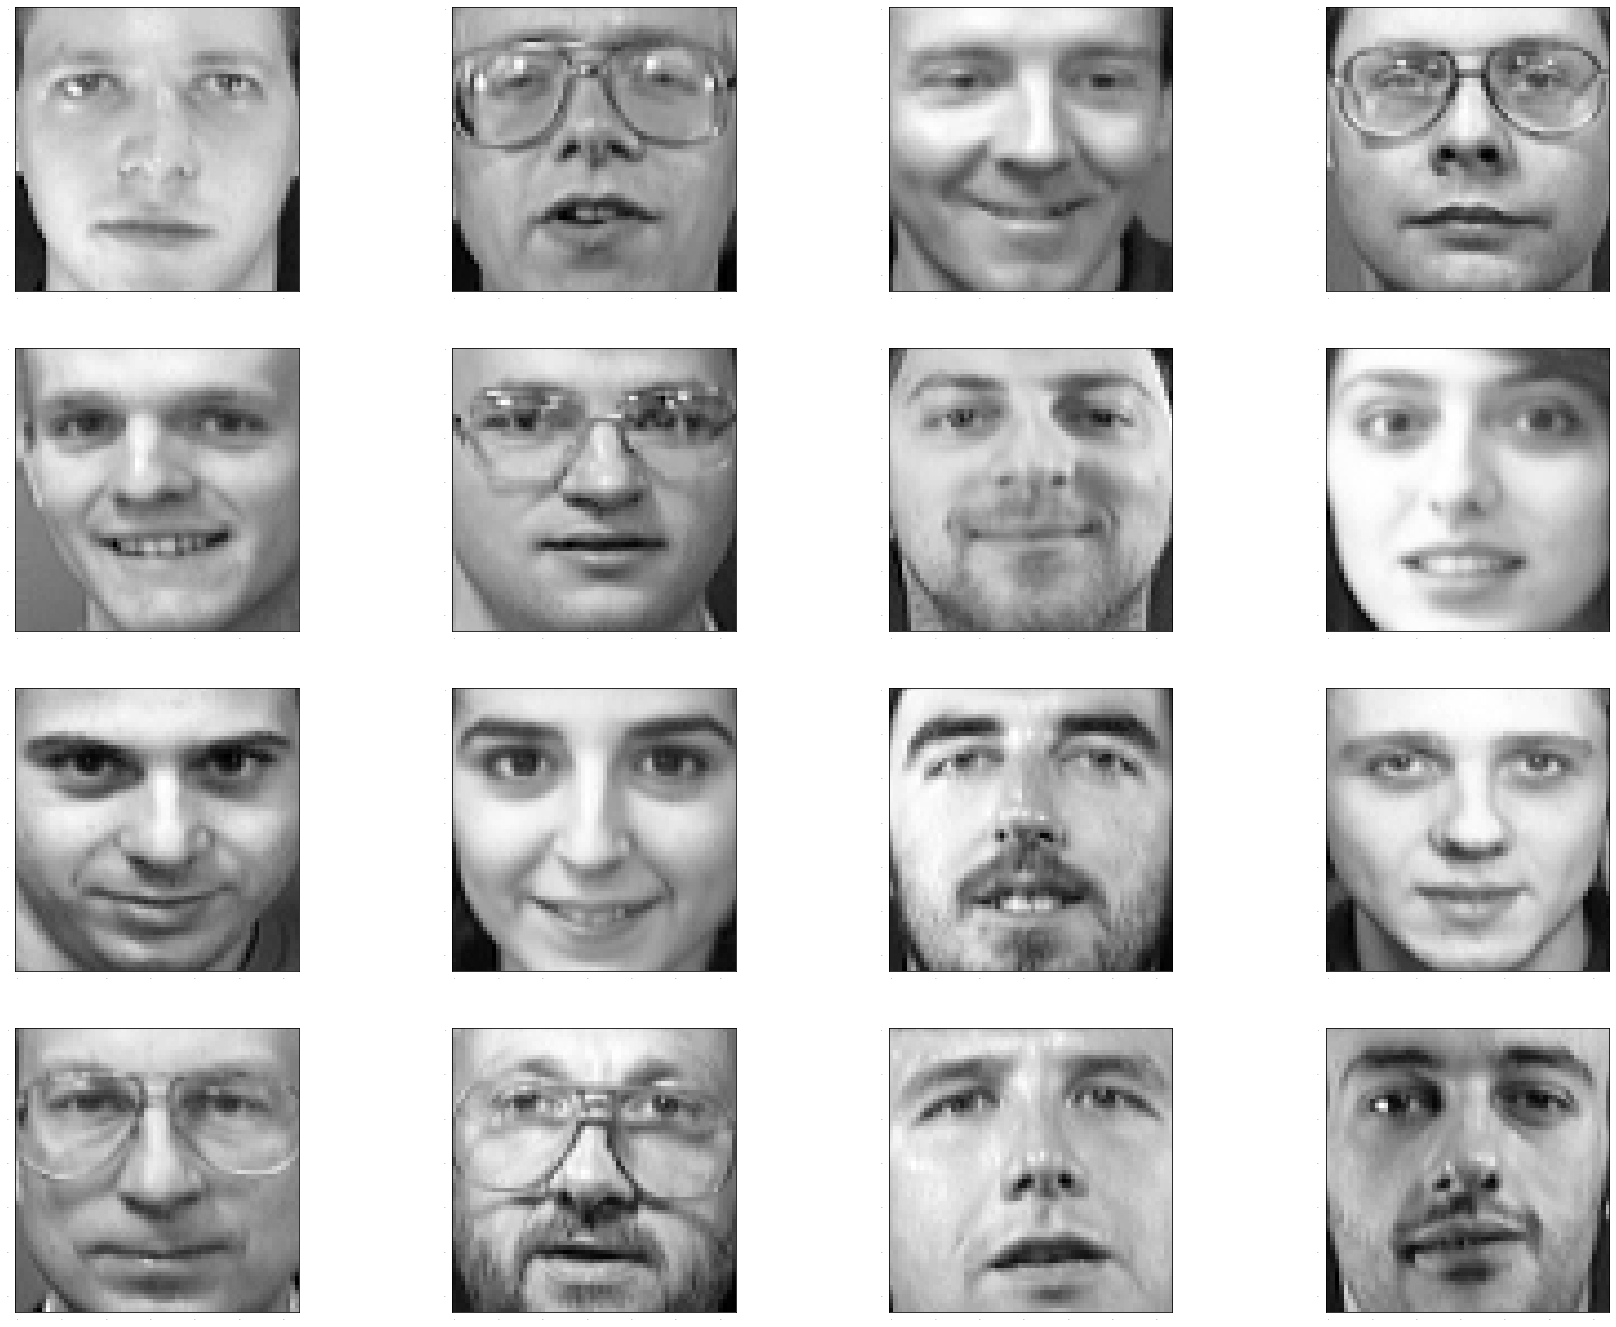

In [4]:
initPlotGrid(4, 16)
for i in range(0, 16):
    addToGrid()
    plt.imshow(faces[i*10].reshape((64, 64)), cmap=plt.cm.gray)
finalizePlotGrid()

# Kompresja

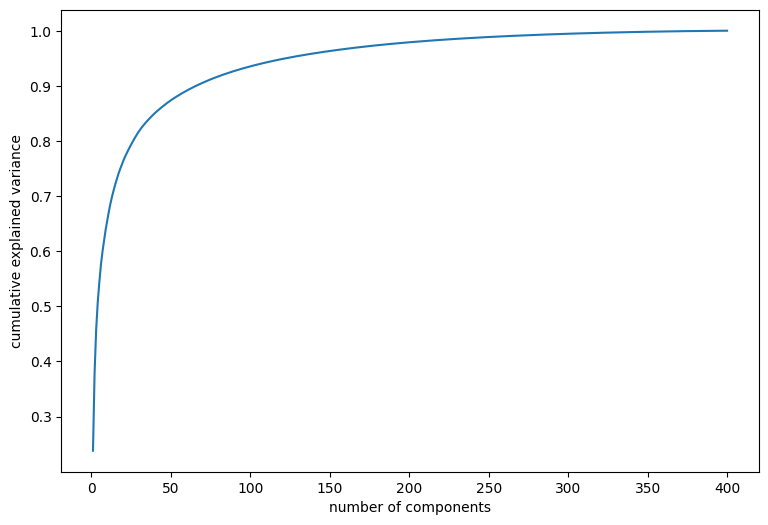

In [39]:
pca = PCA().fit(faces)
pcaCum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pcaCum)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

Jakość kompresji będzie zależała od ilości wybranych kompenentów. Dlatego analizie zostaną poddane różne wartości ilości kompenentów.

In [40]:
pca = {}
sizes = [50, 120, 250]
    
table = pd.DataFrame({}, columns=["Cumulative explained variance", "Compression rate", "Average RMSE", "RMSE variance"])
table = table.rename_axis("N components")

for i in sizes:
    pca[i] = PCA(n_components = i).fit(faces)
    
    transFaces = pca[i].transform(faces)
    comp = faces[0].shape[0] / transFaces.shape[1]
    
    transFaces = pca[i].inverse_transform(transFaces)
    mseAll = []
    for j in range(faces.shape[0]):
        mseAll.append(mse(faces[j], transFaces[j], squared = False))
        
    table.loc[i] = [pcaCum[i], comp, np.mean(mseAll), np.var(mseAll)]
table

,Cumulative explained variance,Compression rate,Average RMSE,RMSE variance
N components,,,,
50,0.875774,81.920000,0.048738,0.000060
120,0.949271,34.133333,0.031376,0.000013
250,0.988742,16.384000,0.014580,0.000011


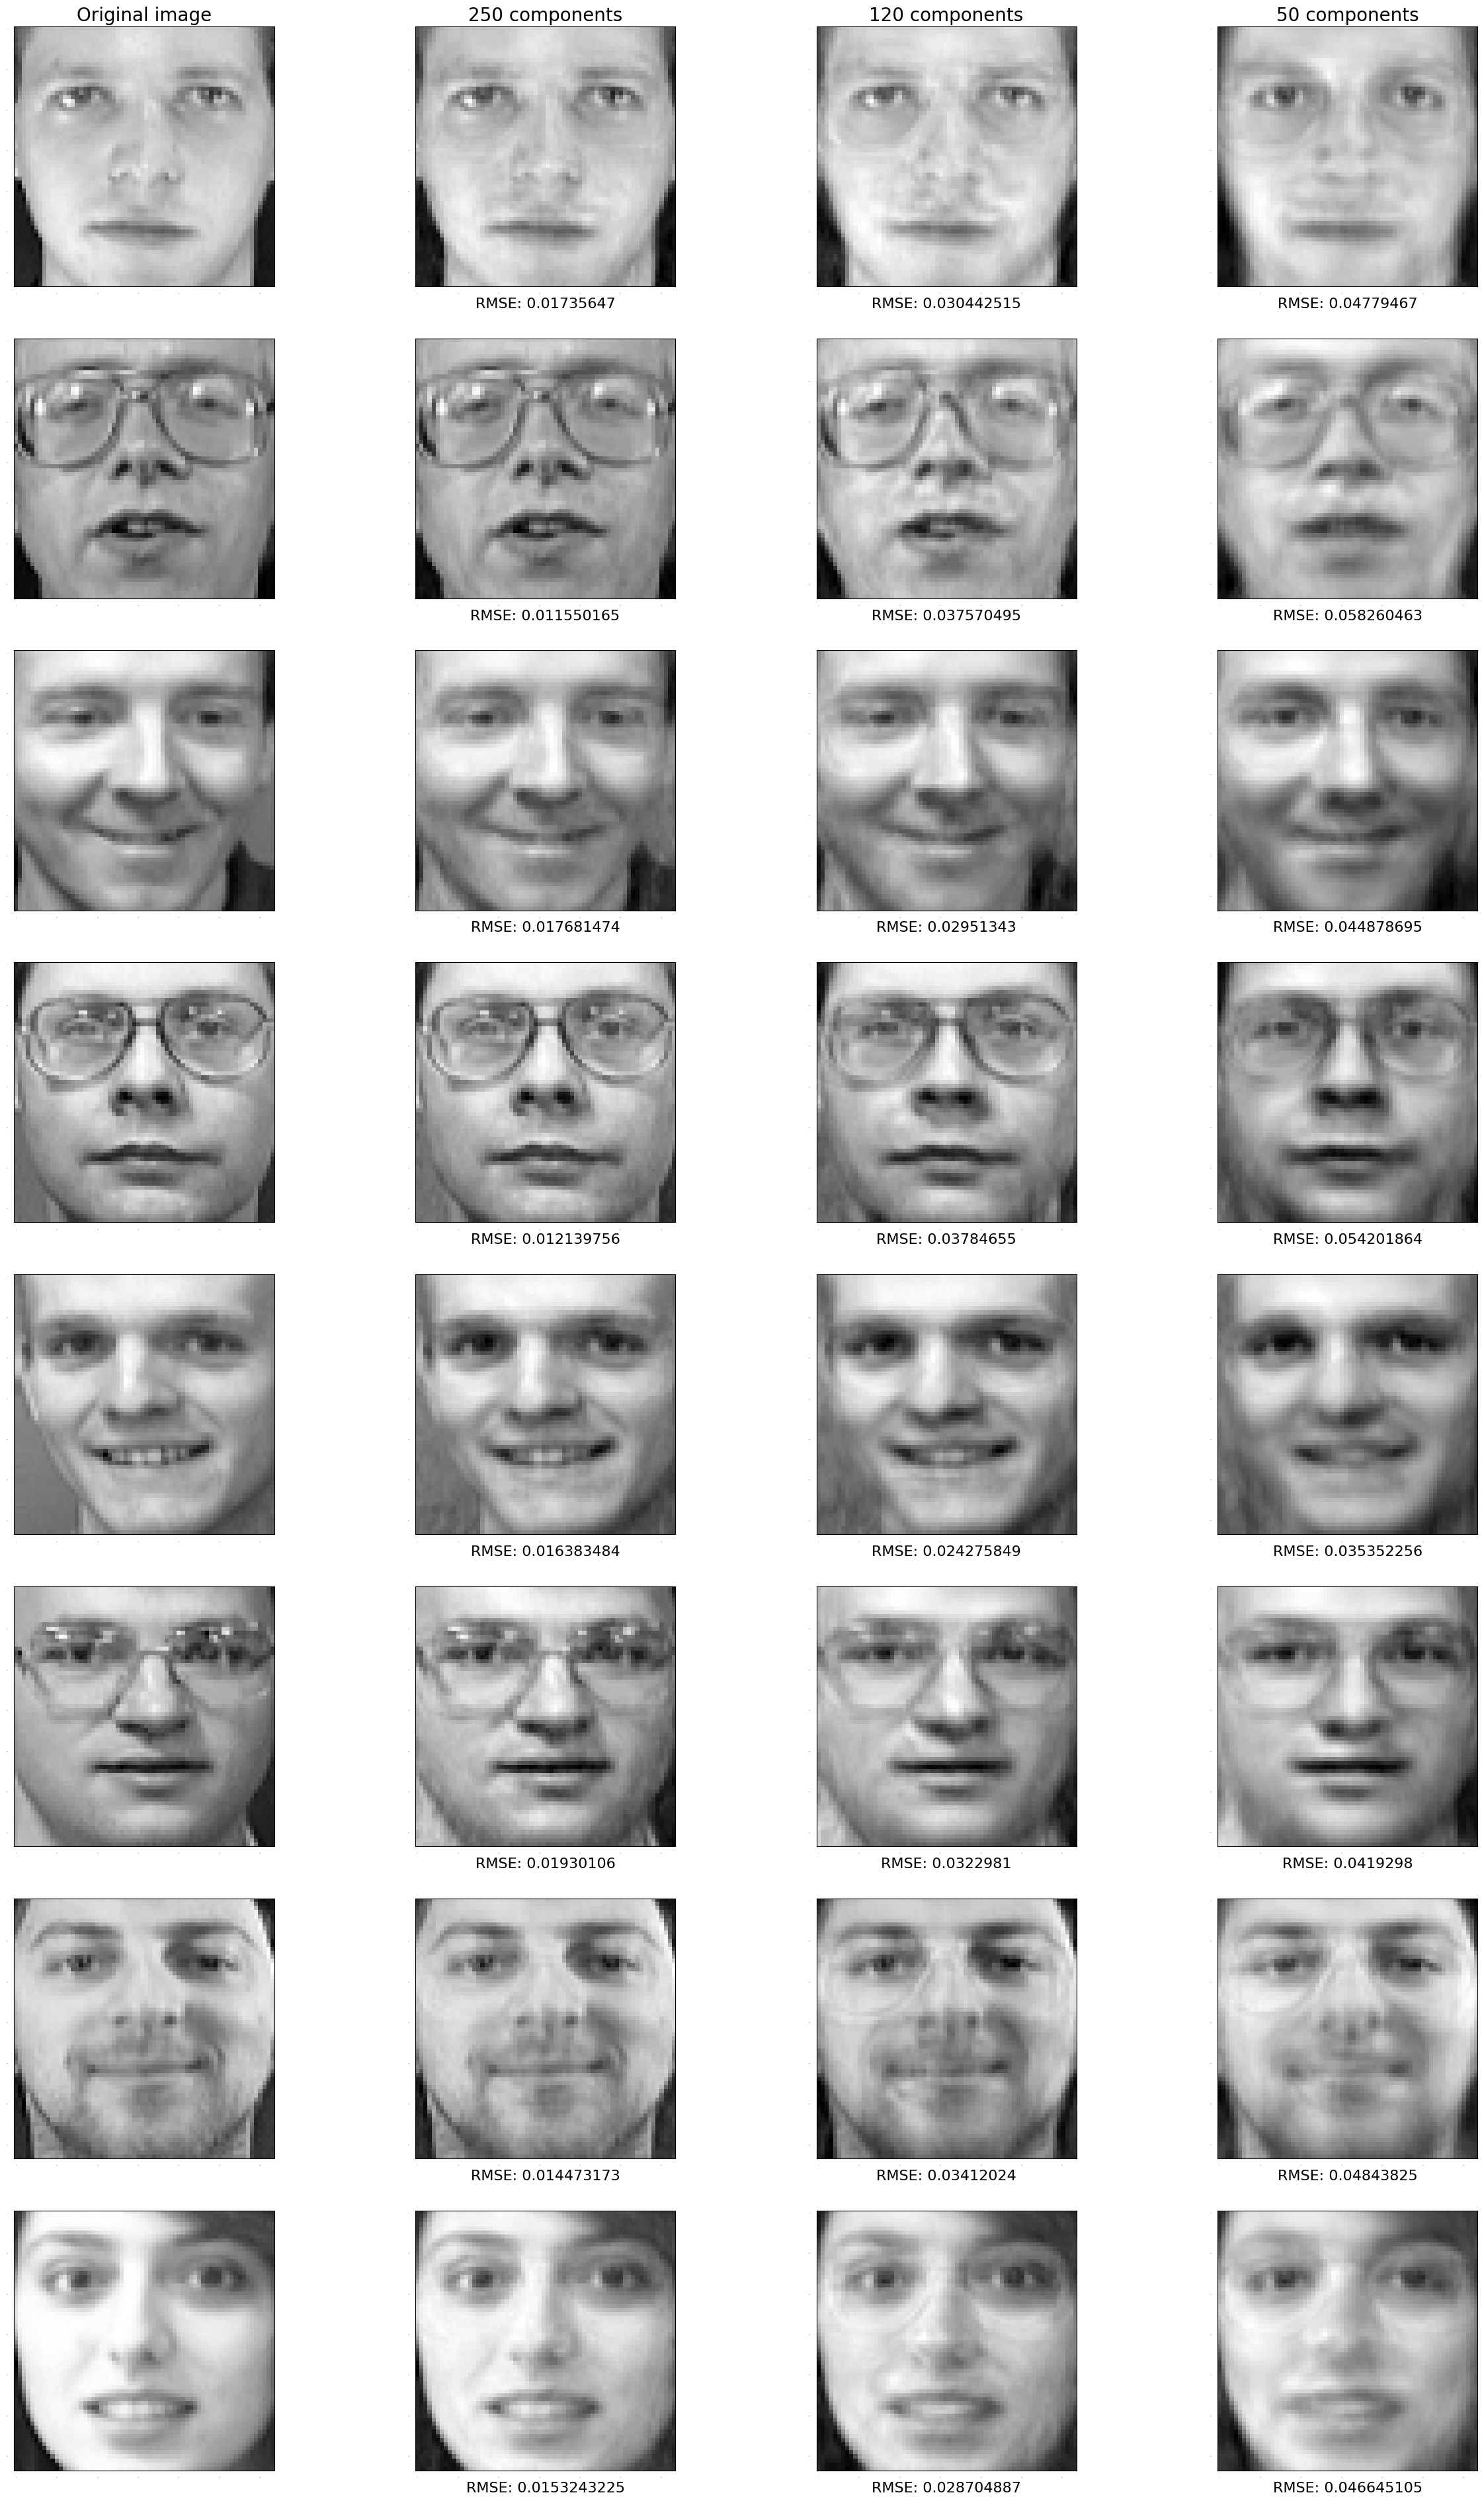

In [46]:
initPlotGrid(1+len(sizes), 8+len(sizes)*8)
for i in range(0, 8):
    face = faces[i*10]
    addToGrid()
    plt.imshow(face.reshape((64, 64)), cmap=plt.cm.gray)
    if(i == 0): plt.title("Original image", fontsize=20)
    
    face = face.reshape(1, -1)
    for j in sizes[::-1]:
        addToGrid()
        p = pca[j]
        transFace = p.inverse_transform(p.transform(face))
        plt.imshow(transFace.reshape((64, 64)), cmap=plt.cm.gray)
        plt.xlabel("RMSE: "+str(mse(face[0], transFace[0], squared = False)), fontsize=16)
        if(i == 0): plt.title(str(j)+" components", fontsize=20)
    
finalizePlotGrid()

Od razu widać wpływ ilości komponentów na jakość kompresji. Dla największej wartości zdjęcie po kompresji i dekompresji dla ludzkiego oka wygląda niemal identycznie do zdjęcia orginalnego, mimo że rozmiar danych jest znacząco mniejszy. Przy mniejszych wartościach widać jednak różnice - wokół oczu pojawiają się obwódki przypominające okulary, zmienia się kąt twarzy do kamery a samo zdjęcie jest dużo bardziej rozmyte.

# Transformacje

In [84]:
modifiers = {}
modifiers["Horizontal flip"] = lambda x : x[:, ::-1]
modifiers["Color inversion"] = invert
modifiers["5 degrees rotation"] = lambda x : transform.rotate(x, 5)
modifiers["20 degrees rotation"] = lambda x : transform.rotate(x, 20)
modifiers["90 degrees rotation"] = lambda x : transform.rotate(x, 90)
modifiers["180 degrees rotation"] = lambda x : transform.rotate(x, 180)

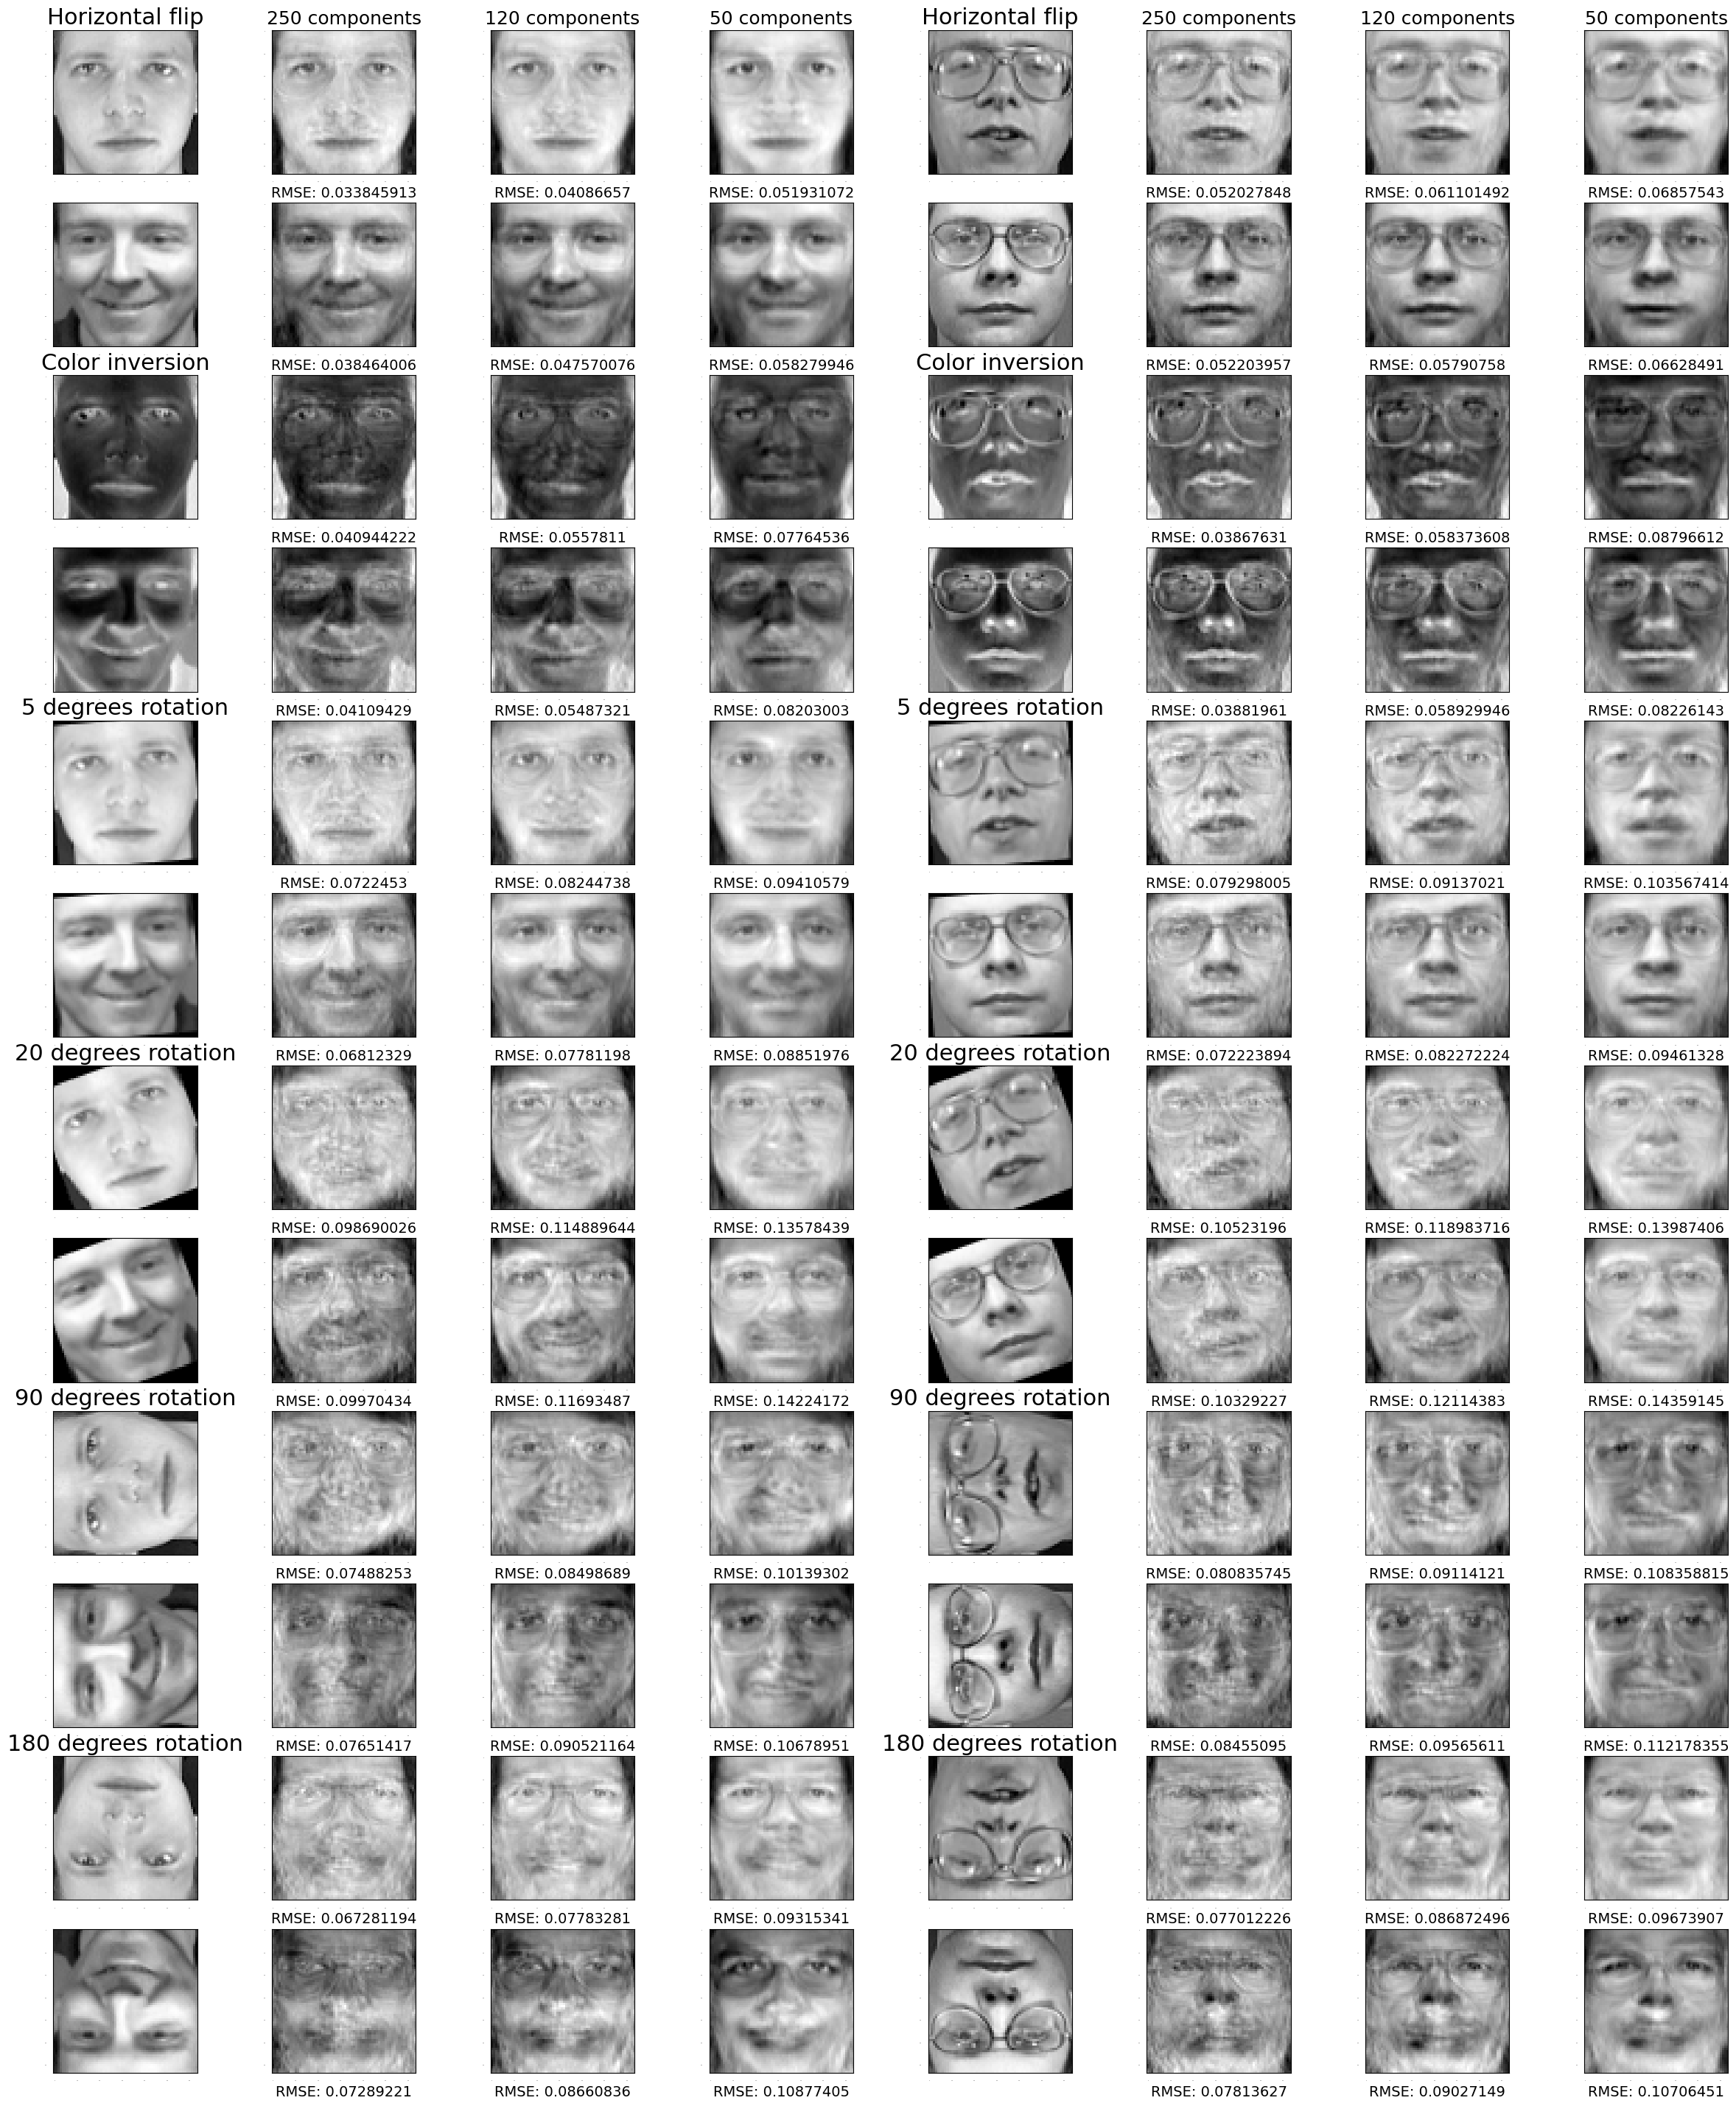

In [85]:
needsTitle = True
initPlotGrid(2+len(sizes)*2, (1+len(sizes))*4*len(modifiers))
for mod in modifiers:
    for i in range(0, 4):
        face = modifiers[mod](faces[i*10].reshape(64, 64)).reshape(1, -1)
        addToGrid()
        plt.imshow(face.reshape((64, 64)), cmap=plt.cm.gray)
        if(i < 2): plt.title(mod, fontsize=22)

        face = face.reshape(1, -1)
        for j in sizes[::-1]:
            addToGrid()
            p = pca[j]
            transFace = p.inverse_transform(p.transform(face))
            plt.imshow(transFace.reshape((64, 64)), cmap=plt.cm.gray)
            plt.xlabel("RMSE: "+str(mse(face[0], transFace[0], squared = False)), fontsize=14)
            if(needsTitle and i < 2): plt.title(str(j)+" components", fontsize=18)
    needsTitle = False
    
finalizePlotGrid()

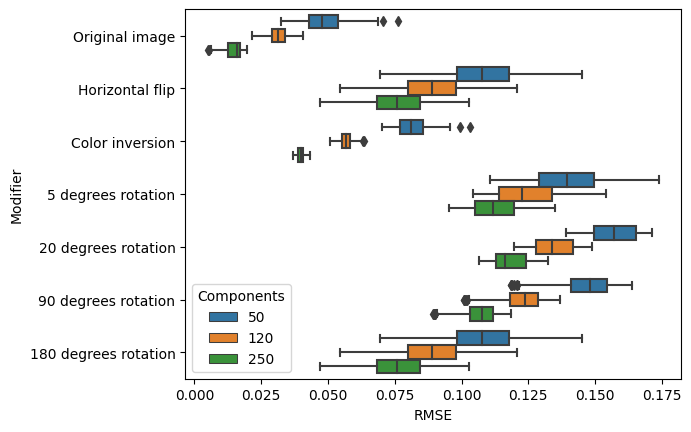

In [92]:
mseData = []
# Display boxplots for non-modified images as well
allMods = {}
allMods["Original image"] = lambda x : x
allMods.update(modifiers)

for mod in allMods:
    for i in sizes:
        modFaces = allMods[mod](faces)
        transFaces = pca[i].transform(modFaces)
        transFaces = pca[i].inverse_transform(transFaces)
        
        for j in range(transFaces.shape[0]):
            mseData.append([mse(modFaces[j], transFaces[j], squared = False), mod, i])
            
mseData = pd.DataFrame(mseData, columns = ["RMSE","Modifier","Components"])
sns.boxplot(data=mseData, y="Modifier", x="RMSE", hue="Components", orient = 'h')
plt.show()

Nawet dla tak prostej tranformacji jak odbicie lustrzane jakość rekompresji drastycznie maleje. Powód dla tego jest prosty - zdjęcie wygenerowane w ten sposób nie zawierały się w zbiorze treningowym PCA. Sugeruje to także że dla zdjęc spoza zbioru treningowa jakość będzie podobna.

Model poradził sobie dosyć dobrze ze zdjęciami w odwróconych kolorach. Podobne wartości wariancji dla wszystkich trzech ilości komponentów względem orginalnych wartości sugerują, że odwrócenie kolorów nie ma duże wpływu na samą strukturę danych.

Model nie radzi sobie ze zdjęciami odwróconymi. Nawet dla tak małego obrócenia jak 5 stopni błąd jest bardzo duży. Paradoksalnie, wyniki dla obrotu 20 stopni są gorsze niż te dla 90 stopni, a te są gorsze niż dla 180 stopni. Jest to najprawdopodobniej spowodowane przez strukturę ludzkiej twarzy (oczy i usta przypominają poziomą linię) oraz przez pozycję niektórych elementów po obrocie (prawe oko po obrocie o 90 stopni znajduje się tam, gdzie wcześniej znajdowało się lewe oko).

Duże różnice w RMSE przy nawet niewielkich obrotach obrazu sugerują że te metoda może być wykorzystana w celu wykrycia obrotów w zdjęciach twarzy.